# Unified SR Model Visualization

This notebook visualizes the results of the Unified Super-Resolution Model.
It compares Low-Resolution (LR), Super-Resolution (SR), and High-Resolution (HR) images side-by-side.

In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.models.unified_model import UnifiedSRModel
from src.utils.metrics import calculate_psnr, calculate_ssim

# Configuration
MODEL_PATH = 'checkpoints/model_final.pth'
SCALE = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

Using device: cpu


In [2]:
# Load Model
model = UnifiedSRModel(upscale=SCALE).to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print("Model loaded successfully.")
    model.eval()
else:
    print(f"Error: Model not found at {MODEL_PATH}")

Model loaded successfully.


In [3]:
def visualize_sample(lr_path, hr_path=None, domain=None):
    # Read Image
    lr_img = cv2.imread(lr_path)
    if lr_img is None:
        print(f"Error reading {lr_path}")
        return
        
    # Preprocess
    lr_img_rgb = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
    lr_tensor = torch.from_numpy(lr_img_rgb.transpose((2, 0, 1))).float() / 255.0
    lr_tensor = lr_tensor.unsqueeze(0).to(DEVICE)
    
    # Inference
    with torch.no_grad():
        sr_tensor, domain_logits = model(lr_tensor, domain)
        
        # Predicted Domain
        if domain is None:
            pred_idx = torch.argmax(domain_logits, dim=1).item()
            pred_domain = 'medical' if pred_idx == 0 else 'satellite'
        else:
            pred_domain = domain
            
    # Postprocess
    sr_img = sr_tensor.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    sr_img = np.clip(sr_img, 0, 1) * 255.0
    sr_img = sr_img.round().astype(np.uint8)
    
    # Metrics
    psnr, ssim = 0, 0
    hr_img_rgb = None
    if hr_path and os.path.exists(hr_path):
        hr_img = cv2.imread(hr_path)
        hr_img_rgb = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
        
        # Resize SR to match HR if needed (should match if scale is correct)
        h, w = hr_img_rgb.shape[:2]
        sr_img = cv2.resize(sr_img, (w, h))
        
        psnr = calculate_psnr(hr_img_rgb, sr_img)
        ssim = calculate_ssim(hr_img_rgb, sr_img)
    
    # Plot
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title(f"Low Resolution ({pred_domain})")
    plt.imshow(lr_img_rgb)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title(f"Super Resolution\nPSNR: {psnr:.2f} | SSIM: {ssim:.4f}")
    plt.imshow(sr_img)
    plt.axis('off')
    
    if hr_img_rgb is not None:
        plt.subplot(1, 3, 3)
        plt.title("High Resolution (Ground Truth)")
        plt.imshow(hr_img_rgb)
        plt.axis('off')
        
    plt.show()

## Medical Samples

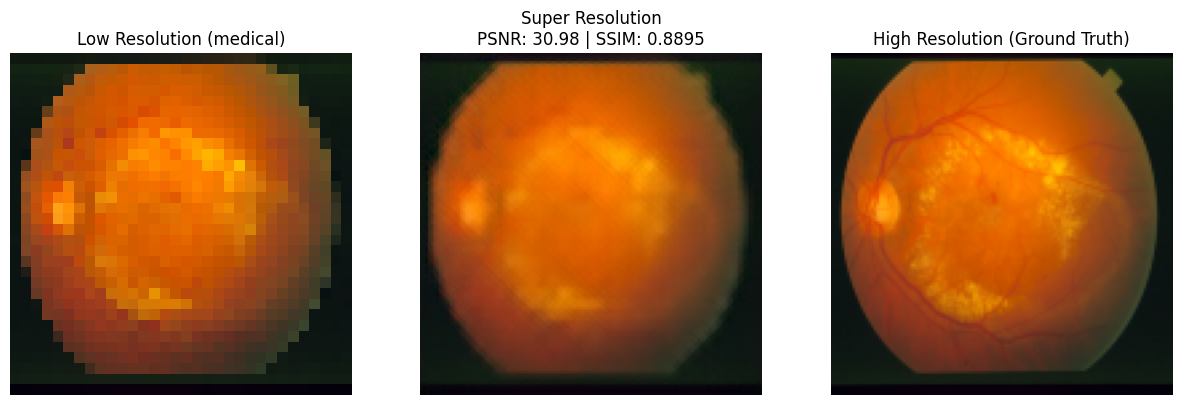

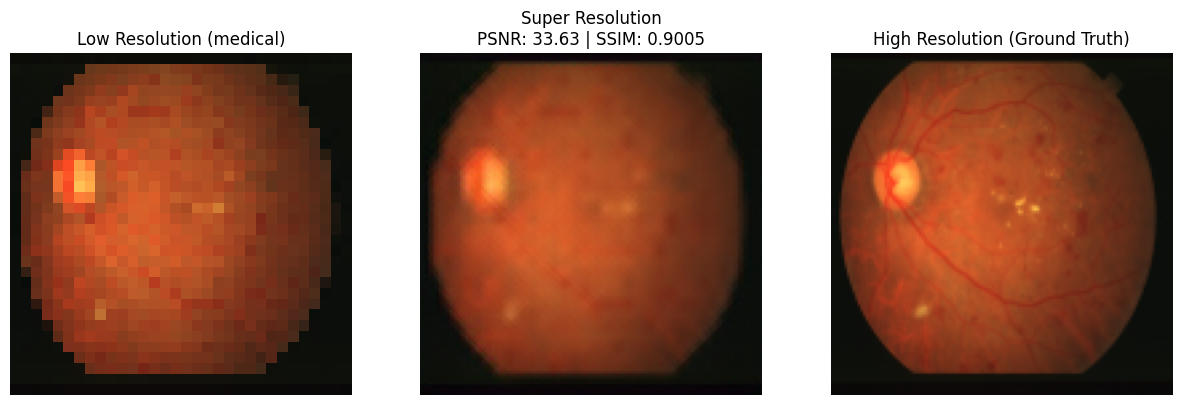

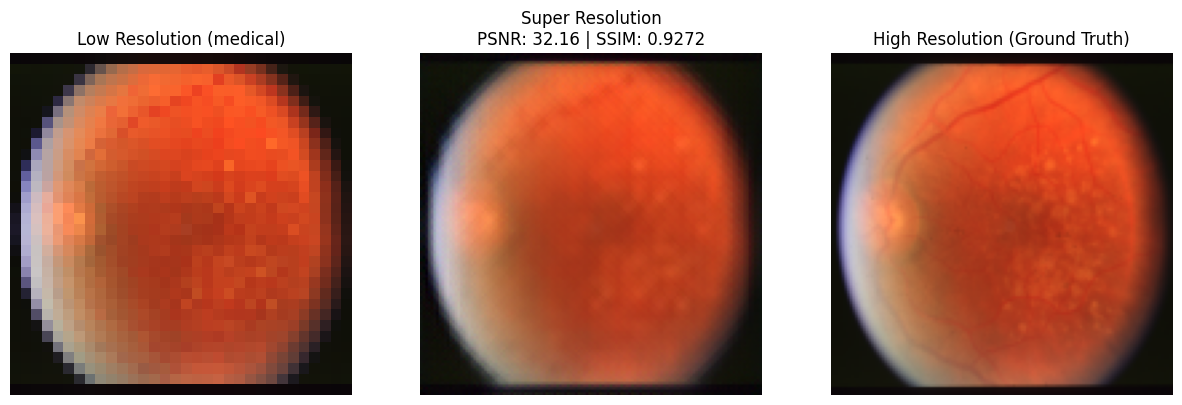

In [4]:
# Visualize random medical samples
med_val_lr = 'data/medical/val/lr'
med_val_hr = 'data/medical/val/hr'

if os.path.exists(med_val_lr):
    files = [f for f in os.listdir(med_val_lr) if f.endswith('.ppm')]
    for f in files[:3]: # Show first 3
        lr_path = os.path.join(med_val_lr, f)
        # HR filenames might be prefixed with 'resized_'
        hr_path = os.path.join(med_val_hr, f"resized_{f}")
        if not os.path.exists(hr_path):
             hr_path = os.path.join(med_val_hr, f)
             
        visualize_sample(lr_path, hr_path)

## Satellite Samples

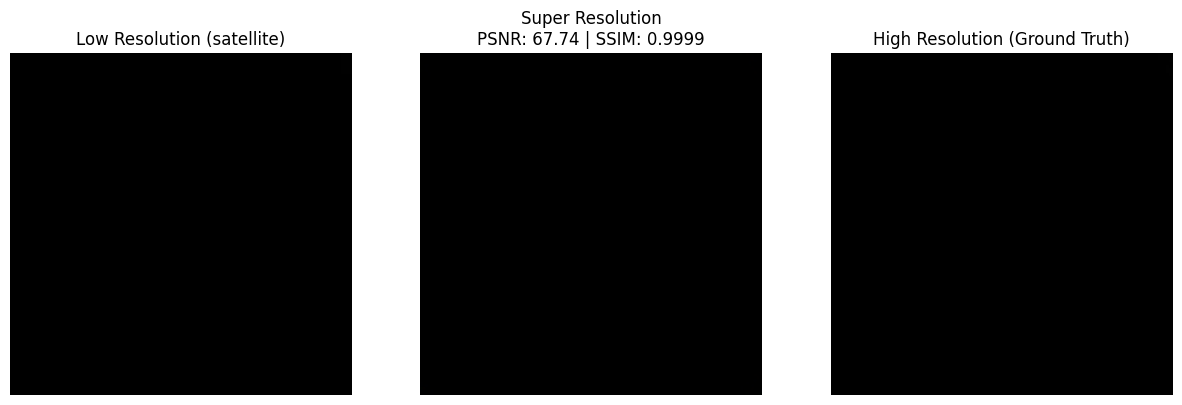

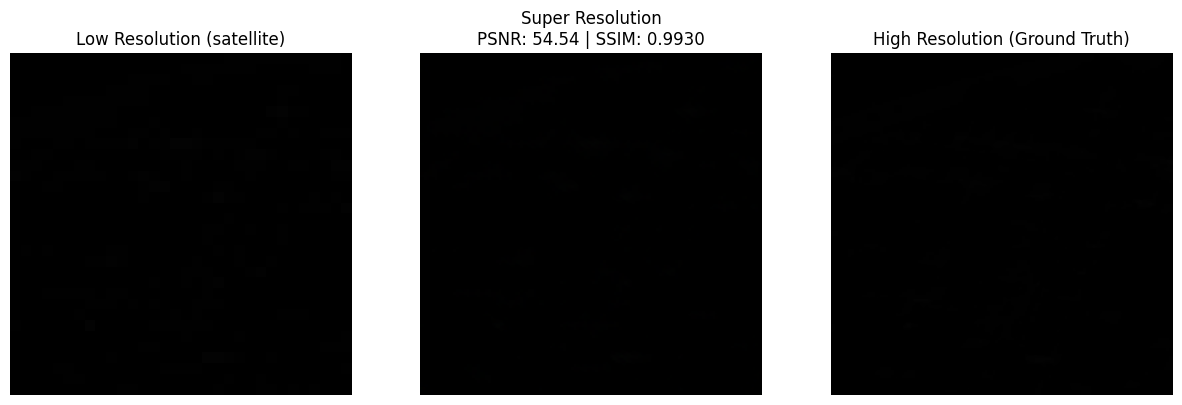

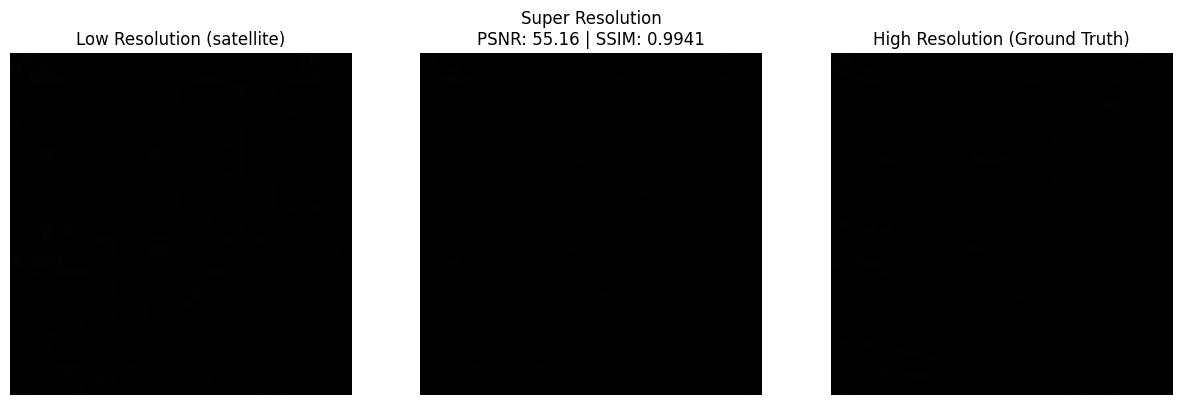

In [5]:
# Visualize random satellite samples
sat_val_lr = 'data/satelitte/val/lr'
sat_val_hr = 'data/satelitte/val/hr'

if os.path.exists(sat_val_lr):
    files = [f for f in os.listdir(sat_val_lr) if f.endswith('.tif') or f.endswith('.png')]
    for f in files[:3]: # Show first 3
        lr_path = os.path.join(sat_val_lr, f)
        hr_path = os.path.join(sat_val_hr, f"resized_{f}")
        if not os.path.exists(hr_path):
             hr_path = os.path.join(sat_val_hr, f)
             
        visualize_sample(lr_path, hr_path)